# Solving the Poisson's equation using VQE

Author: Zhixin Song \
Last update: 09/22/2023

## 1. Introduction

Poisson's equation is $\Delta \phi = f$, where $\Delta = \nabla^2$ is the Laplace operator. It is widely used in theoretical physics, including electrostatistics and gravitational field. In Cartesian coordinates, it takes the form

$$
\bigg(\frac{\partial^2}{\partial x^2} +\frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2}\bigg)\phi(x,y,z) = f(x,y,z).
$$

Here, we only consider the 1D case for simplicity. We will disscuss how to generalize it to higher dimensions in a different tutorial. Also, we consider the Dirichlet boundary conditions (B.C.s) in domain $[a,b]$.

$$
\Delta \phi(x)= \frac{\partial^2 \phi(x)}{\partial x^2} = f(x), \text{  with    } \phi(a) = \phi_a, \phi(b) = \phi_b.
$$

The classical approach to solve this type of PDE is discretizing the spatial domain into a grid mesh of $m$ points such that we can approximate the differential operator with a difference operator

$$
\Delta \phi(x) \approx \frac{\phi_{i-1} - 2 \phi_i + \phi_{i+1}}{h^2},
$$

where $h = (b-a)/(m-1)$ is the separation between each grid point. Then, we can tramsform the orginal problem of solving PDE into a linear system $Ax=b$ where

$$
A = 
\begin{bmatrix}
    -2 &1 &0 &\cdots &0 &0 &0\\
    1 &-2 &1 &\cdots &0 &0 &0\\
    \vdots &\vdots &\vdots &\ddots &\vdots &\vdots &\vdots\\
    0 &0 &0 &\cdots &1 &-2 &1\\
    0 &0 &0 &\cdots &0 &1 &-2
\end{bmatrix},
b = 
\begin{bmatrix}
    h^2f_1 - \phi_a \\
    h^2 f_2 \\
    \vdots \\
    h^2 f_{m-1} \\
    h^2 f_m - \phi_b
\end{bmatrix}.
$$

The error from such an discretization procedure decreases exponentially with the size of grid. On a classical computer, one can solve this linear system using Gaussian elimination with Matlab when the problem size is small. 

## 2. Quantum Solution

Notice that a quantum state actually maps to an **exponential** grid size. Therefore the amount of quantum resources is linear in number of qubits $n$ and the discretization error decreases exponentially $\mathcal{O}(1/2^n)$. There are multiple routes to solve this linear system. For the long-term view, one would use the HHL algorithm for speedup. On NISQ machines, we consider the Variational Quantum Eigensolver (VQE).

First of all, we need to transfer the problem into a Hamiltonian $H$ where

$$
H = A^\dagger(I - |b\rangle\langle b|) A
$$

In order to see how this works, we can try to plug into the solution $|x\rangle$

$$
H |x\rangle = A^\dagger(I - |b\rangle\langle b|) A |x\rangle = A^\dagger(I - |b\rangle\langle b|) |b\rangle
= A^\dagger(|b\rangle - |b\rangle) = 0 |x\rangle. 
$$

One can see that the solution is encoded in the ground state of $H$ with an eigenvalue of $0$. Then, we can use VQE to find the ground state.

**Note**: Quantum solvers uaually find a normalized solution $|x\rangle/||x||$.

## 3. Numerics

Consider the driving function $f(x)=x$, boundary $[a,b]= [0,1]$ and boundary conditions $\phi_a = \phi_b=0$. Then, the analytical solution is $\phi(x)=(x^3-x)/6$.

In [1]:
from IPython.display import clear_output
!pip install qiskit==0.39.0
clear_output()

### 3.0 Setup backend

In [16]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter

from qiskit import IBMQ
IBMQ.save_account('c7a71bc4b2858304571d35eb5e371e449e5c346110b36c744f51b65388d4ac1b7468740d58d6fcd44967b2080d02af986cc22f2406a84813bbabd9ff5bf06315')
IBMQ.load_account() # Load account from disk
IBMQ.providers()    # List all available providers
# provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
# guadalupe = provider.get_backend("ibmq_guadalupe")


from qiskit.providers.fake_provider import FakeGuadalupe

# Noisy simulator backend
noisy_sim = FakeGuadalupe()

from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

configrc.store_credentials:WARNING:2023-09-22 13:42:48,802: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2023-09-22 13:42:49,062: Credentials are already in use. The existing account in the session will be replaced.


### 3.1 Encode the problem Hamiltonian

In [17]:
import numpy as np
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 16})  # enlarge matplotlib fonts

from qiskit.opflow import MatrixOp

In [18]:
total_res = {}

N = 4   # number of qubits
dim = 2**N # dimension of the operator A

# Setup a tridiagonal matrix
k = [np.ones(dim-1), -2*np.ones(dim), np.ones(dim-1)]
offset = [-1, 0, 1]
A = diags(k,offset).toarray()

# Setup the driving term f(x) = x
b = np.linspace(0, 1, dim)
h = 1/(dim-1)
sampled_b = b*(h**2)
bt = np.linspace(0, 1, dim)

# Setup the Dirichlet B.C.s
phi_a, phi_b = 0, 0
sampled_b[0] -= phi_a
sampled_b[dim-1] -= phi_b
norm = np.linalg.norm(sampled_b)
sampled_b = sampled_b/norm

# Solve the linear system of equations
x = np.linalg.solve(A, sampled_b)
f = np.linalg.norm(x)
x = x/f

# Build Hamiltonian
sampled_b = sampled_b.reshape([dim, 1])
Hamiltonian = A@(np.eye(dim)- sampled_b@sampled_b.T)@A
# print(Hamiltonian)

print("Classical solution:\n", x)
eig_val, eig_state = np.linalg.eig(Hamiltonian)
# print("Eigenvalues:\n", eig_val)
# print(min(eig_val))
vec = eig_state[:,-1]
# print(eig_state)
print("Eigenvector:\n", -vec)

# Transform into Pauli operators
H_op = MatrixOp(Hamiltonian).to_pauli_op()
print("Lenth of Pauli String:",len(H_op))
print(H_op)

Classical solution:
 [-0.04853869 -0.09707737 -0.14440259 -0.18930087 -0.23055876 -0.26696277
 -0.29729945 -0.32035532 -0.33491693 -0.3397708  -0.33370346 -0.31550146
 -0.28395131 -0.23783956 -0.17595273 -0.09707737]
Eigenvector:
 [-0.04853869 -0.09707737 -0.14440259 -0.18930087 -0.23055876 -0.26696277
 -0.29729945 -0.32035532 -0.33491693 -0.3397708  -0.33370346 -0.31550146
 -0.28395131 -0.23783956 -0.17595273 -0.09707737]
Lenth of Pauli String: 38
SummedOp([
  5.862046370967742 * IIII,
  -4.0 * IIIX,
  0.01285282258064524 * IIIZ,
  IIXI,
  -2.0 * IIXX,
  -2.0 * IIYY,
  0.012852822580645018 * IIZI,
  -0.13795362903225805 * IIZZ,
  0.5 * IXXI,
  -1.0 * IXXX,
  IXYY,
  -1.0 * IYXY,
  0.5 * IYYI,
  -1.0 * IYYX,
  0.012852822580645185 * IZII,
  -0.1379536290322581 * IZIZ,
  -0.1379536290322581 * IZZI,
  0.012852822580645185 * IZZZ,
  0.25 * XXXI,
  -0.49838709677419357 * XXXX,
  0.49838709677419357 * XXYY,
  0.49838709677419357 * XYXY,
  -0.25 * XYYI,
  0.49838709677419357 * XYYX,
  -0.501

### 3.2 Ansatz design

In [19]:
from qiskit.circuit.library import EfficientSU2

depth = 5 # depth of ansatz
ansatz = EfficientSU2(N, entanglement='linear', reps=depth, skip_final_rotation_layer=True).decompose()
ansatz.draw(fold=300)

┌──────────┐┌──────────┐     ┌──────────┐┌───────────┐                          ┌───────────┐┌───────────┐                          ┌───────────┐┌───────────┐                          ┌───────────┐┌───────────┐                                    
q_0: ┤ Ry(θ[0]) ├┤ Rz(θ[4]) ├──■──┤ Ry(θ[8]) ├┤ Rz(θ[12]) ├───────────────────■──────┤ Ry(θ[16]) ├┤ Rz(θ[20]) ├───────────────────■──────┤ Ry(θ[24]) ├┤ Rz(θ[28]) ├───────────────────■──────┤ Ry(θ[32]) ├┤ Rz(θ[36]) ├───────────────────■────────────────
     ├──────────┤├──────────┤┌─┴─┐└──────────┘└┬──────────┤┌───────────┐    ┌─┴─┐    └───────────┘├───────────┤┌───────────┐    ┌─┴─┐    └───────────┘├───────────┤┌───────────┐    ┌─┴─┐    └───────────┘├───────────┤┌───────────┐    ┌─┴─┐              
q_1: ┤ Ry(θ[1]) ├┤ Rz(θ[5]) ├┤ X ├─────■───────┤ Ry(θ[9]) ├┤ Rz(θ[13]) ├────┤ X ├──────────■──────┤ Ry(θ[17]) ├┤ Rz(θ[21]) ├────┤ X ├──────────■──────┤ Ry(θ[25]) ├┤ Rz(θ[29]) ├────┤ X ├──────────■──────┤ Ry(θ[33]) ├┤ Rz(θ[37]) ├────┤ X ├──────■───────
     ├──────────┤├──────────┤└───┘   ┌─┴─┐     └──────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───┴───┴───┐┌─┴─┐     
q_2: ┤ Ry(θ[2]) ├┤ Rz(θ[6]) ├────────┤ X ├──────────■──────┤ Ry(θ[10]) ├┤ Rz(θ[14]) ├────┤ X ├──────────■──────┤ Ry(θ[18]) ├┤ Rz(θ[22]) ├────┤ X ├──────────■──────┤ Ry(θ[26]) ├┤ Rz(θ[30]) ├────┤ X ├──────────■──────┤ Ry(θ[34]) ├┤ Rz(θ[38]) ├┤ X ├──■──
     ├──────────┤├──────────┤        └───┘        ┌─┴─┐    ├───────────┤├───────────┤    └───┘        ┌─┴─┐    ├───────────┤├───────────┤    └───┘        ┌─┴─┐    ├───────────┤├───────────┤    └───┘        ┌─┴─┐    ├───────────┤├───────────┤└───┘┌─┴─┐
q_3: ┤ Ry(θ[3]) ├┤ Rz(θ[7]) ├─────────────────────┤ X ├────┤ Ry(θ[11]) ├┤ Rz(θ[15]) ├─────────────────┤ X ├────┤ Ry(θ[19]) ├┤ Rz(θ[23]) ├─────────────────┤ X ├────┤ Ry(θ[27]) ├┤ Rz(θ[31]) ├─────────────────┤ X ├────┤ Ry(θ[35]) ├┤ Rz(θ[39]) ├─────┤ X ├
     └──────────┘└──────────┘                     └───┘    └───────────┘└───────────┘                 └───┘    └───────────┘└───────────┘                 └───┘    └───────────┘└───────────┘                 └───┘    └───────────┘└───────────┘     └───┘

### 3.3 Transpile

In [22]:
ansatz_opt = transpile(ansatz, backend=noisy_sim, optimization_level=1)

print('number and type of gates in the cirucit:', ansatz_opt.count_ops())
print('number of parameters in the circuit:', ansatz_opt.num_parameters)
ansatz_opt.draw(fold=300)

KeyboardInterrupt: 

### 3.4 Optimizer

In [23]:
from qiskit.algorithms.optimizers import SPSA, COBYLA, L_BFGS_B, NELDER_MEAD, SLSQP, ADAM, AQGD, CG, POWELL, QNSPSA

# optimizer = SPSA(maxiter=500)
optimizer  = L_BFGS_B(maxiter=5000)
# optimizer  = ADAM(maxiter=200, lr=0.2)
# optimizer  = AQGD(maxiter=1000, eta=1.0, tol=1e-06, momentum=0.25, param_tol=1e-06, averaging=10)
# optimizer  = POWELL()
# optimizer  = COBYLA(maxiter=10000)
# optimizer  = SLSQP(maxiter=10000)

### 3.5 Define VQE program

In [24]:
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE

quantum_instance = QuantumInstance(backend=backend, seed_simulator=28, seed_transpiler=28,
                                        basis_gates=None,
                                        optimization_level=3)

In [25]:
best_result = 99999

vqe = VQE(ansatz_opt, optimizer,quantum_instance=quantum_instance,initial_point=2*np.pi*np.random.rand(ansatz_opt.num_parameters))
result = vqe.compute_minimum_eigenvalue(H_op)
quantum_solution = -1*np.abs(result.eigenstate).real
print(quantum_solution)

if result.eigenvalue.real < best_result:
    best_result = result.eigenvalue.real
    kept_result = result
print("Current round using ansatz TwoLocal with depth {}, found eigenvalue {}. Best so far {}".format(depth, result.eigenvalue.real,best_result))
total_res.update({(N, depth):kept_result})

[-0.04857149 -0.09704897 -0.14429974 -0.18913409 -0.23033171 -0.2667281
 -0.29715948 -0.32035994 -0.33509122 -0.34003248 -0.33394463 -0.31560132
 -0.28391917 -0.23776634 -0.17584391 -0.09696355]
Current round using ansatz TwoLocal with depth 5, found eigenvalue 4.92379562022e-07. Best so far 4.92379562022e-07


### 3.6 Convergence Analysis

### 3.7 Benchmark with analytical solution

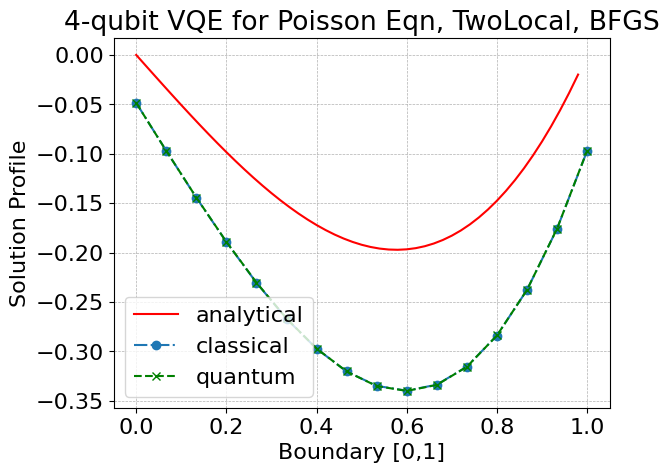

In [26]:
t = np.arange(0., 1., 0.02)
res = (t**3-t)/6
norm_res = np.linalg.norm(res)
res_norm = res/norm_res

xt = np.arange(0,1,1/dim)
exact = [1/6*(x**3-x) for x in np.arange(0,1,1/dim)]
norm = np.linalg.norm(exact)
exact = exact/norm

# red dashes, blue squares and green triangles
plt.plot(t, res_norm, 'r-', label='analytical')
plt.plot(bt, x, 'o-.', label='classical')
plt.plot(bt, quantum_solution, 'gx--', label='quantum')
# plt.legend()
plt.legend(loc="lower left")
plt.xlabel('Boundary [0,1]')
plt.ylabel('Solution Profile')
plt.title("4-qubit VQE for Poisson Eqn, TwoLocal, BFGS")
plt.grid(linestyle = '--', linewidth = 0.5)
# plt.show()
# plt.savefig("Poisson.png", bbox_inches='tight', dpi=300)

In [14]:
import qiskit.tools.jupyter
%qiskit_version_table